In [1]:
%matplotlib inline

# Using YouTube API to Analyze Mr. Beast's Videos' Metrics

This is a short project that utlizes YouTube's publicly available and well-documented API to access information on YouTube such as, but not limited to: video statistics, channel statistics, user information, playlist information, etc.

In this project the goal is to analyze the last 50 videos that Mr. Beast uploaded and see if we can draw any insights from our data. (We analyze the last 50 videos because that is the video limit amount that I can access using the methods utilized.)

# Imports

In [2]:
from googleapiclient.discovery import build
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl

# API Key
<br>

The api key is your credential provided from google to access the YouTube API and YouTube information. Do not share your key with anyone as this will enable anyone to access YouTube data on your behalf.

In [3]:
#your api key goes here BUT DO NOT SHARE IT WITH ANYONE
api_key = "" 

#accessing YouTube v3 API
youtube = build(serviceName="youtube", version="v3", developerKey=api_key)

# Getting Uploads ID
<br>

We need to get the id for Mr.Beast's channel uploads. We can do this if we know the channel's unique ID or their username. Unfortunately, the channel ID isn't very straightforward to get anymore. There is a way to get the upload ID from the channel's username, but the channel username isn't always the same as the channel's public name (ex. "Mr. Beast" may be the public name of the channel, but not the username of the channel that YouTube's API will recognize. Confusing? Yes, I agree.)

I used this website to get the channel ID of Mr. Beast (https://commentpicker.com/youtube-channel-id.php). Once you have the ID you can just run these next steps and look at the output to see if you have the correct channel.

In [4]:
#This is the usual syntax for accessing the YouTube API where you have to use the .execute() method
request = youtube.channels().list(part = ["contentDetails"],
                                  id = "UCX6OQ3DkcsbYNE6H8uQQuVA") #Mr Beast channel ID

response = request.execute()
print(response)

{'kind': 'youtube#channelListResponse', 'etag': 'mky5yfatRnp-E8N9-BwXGY8W8Dk', 'pageInfo': {'totalResults': 1, 'resultsPerPage': 5}, 'items': [{'kind': 'youtube#channel', 'etag': '-f8h6RTCebSZttPcDz3dTkMV5yo', 'id': 'UCX6OQ3DkcsbYNE6H8uQQuVA', 'contentDetails': {'relatedPlaylists': {'likes': '', 'uploads': 'UUX6OQ3DkcsbYNE6H8uQQuVA'}}}]}


Here we can see at the end of the json file the 'uploads' key with the corresponding playlistID. This is not a playlist, but the pointer to the uploaded videos for the channel.

# Getting Video ID's
<br>
So now we will use this playlistID to access metrics for Mr. Beast's past 50 YouTube videos.

In [5]:
playlistID = "UUX6OQ3DkcsbYNE6H8uQQuVA" 

In [6]:
#json object that lists details for Mr. Beast's most recent 50 videos
mrbeast_vids = youtube.playlistItems().list(part = ["contentDetails", "id", "snippet", "status"],
                             playlistId = playlistID,
                             maxResults = 50).execute() #50 is the max amount of videos you can get at once

#Getting just the video ID's for each video from the json file. The video ID for each YouTube video is unique
vid_ids = [mrbeast_vids["items"][i]['contentDetails']["videoId"] for i in range(len(mrbeast_vids["items"]))]

# Getting Videos' Statistics
<br>
Now that we have the video ID's we can access information on each video and save the relevant information to memory through these lists below. We will get information on comments, likes, views, uploade dates, and video titles.

In [7]:
comments = []
likes = []
views = []
dates = []
titles = []


for vid_id in vid_ids:
    
    #Getting details for each YouTube video
    video_deets = youtube.videos().list(part = "snippet,statistics", id = vid_id).execute()
    
    comments.append(video_deets["items"][0]['statistics']['commentCount'])#comments
    likes.append(video_deets["items"][0]['statistics']['likeCount'])#likes
    views.append(video_deets["items"][0]['statistics']['viewCount'])#views
    dates.append(video_deets["items"][0]["snippet"]["publishedAt"])#date
    titles.append(video_deets["items"][0]["snippet"]["title"])#title

In [8]:
#The dates are formatted a little weird so we do some cleaning
dates = [date[:10] for date in dates]
datetimes = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

In [9]:
#We collect all this data in a pandas dataframe object because that's what I'm used to and it's easy
df = pd.DataFrame(data = {'titles' : titles,
                          'dates' : dates,
                          'datetimes' : datetimes,
                          'likes' : likes,
                          'comments' : comments,
                          'views' : views})

In [10]:
#For some reason these metrics are in a string format so we conver to float
df["views"] = df["views"].apply(lambda x : float(x))
df["comments"] = df["comments"].apply(lambda x : float(x))
df["likes"] = df["likes"].apply(lambda x : float(x))

# Plotting
<br>
Now that the data is clean we can do some plotting. We plot views, likes, comments as a function of upload date. I have also plotted a vertical line for some videos that stood out to me. These stood out because one or more metrics for that video was significantly higher than the other videos' metric(s).

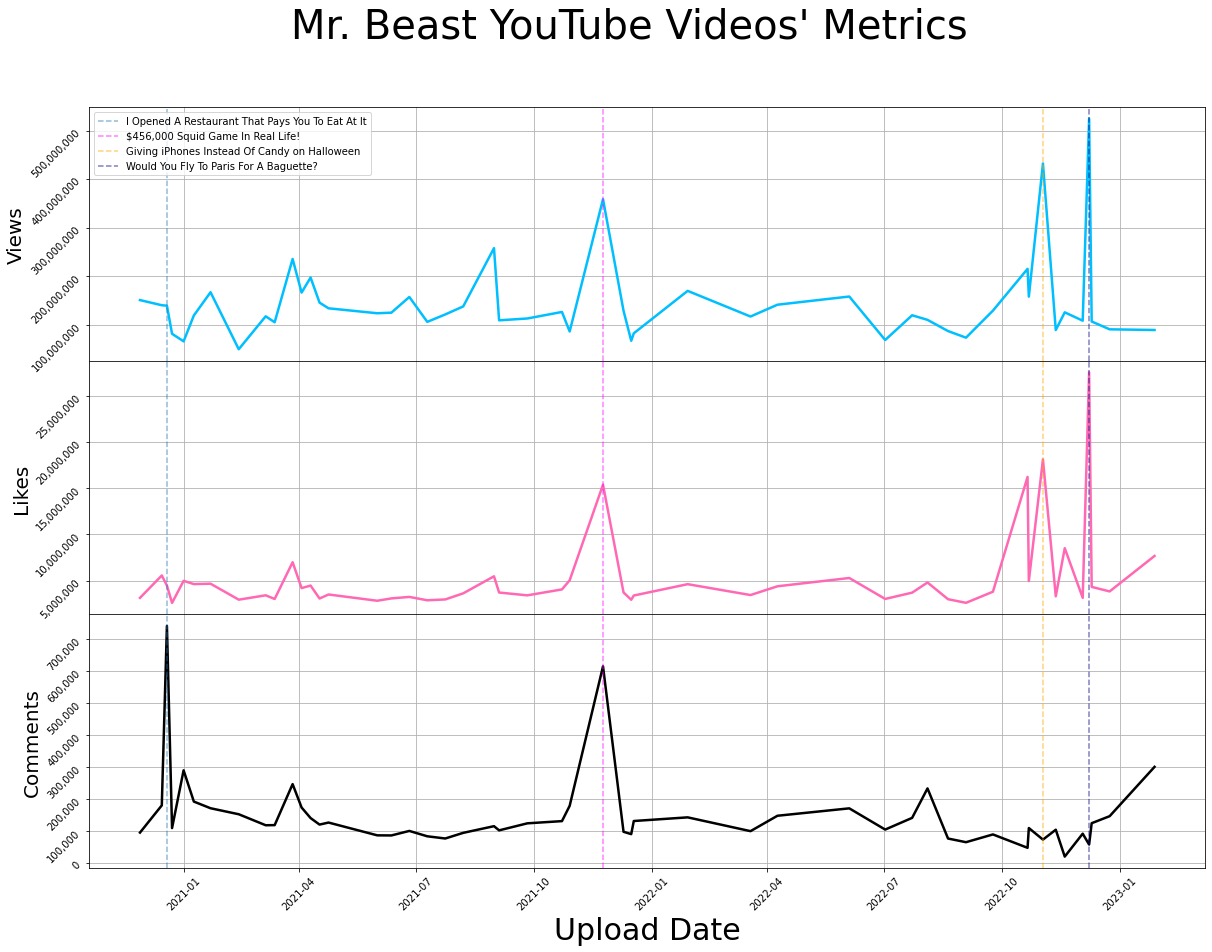

In [11]:
fig, axs = plt.subplots(nrows = 3, figsize = (20,14), sharex=True)

axs[0].plot(df["datetimes"], df["views"], color = "deepskyblue", lw = 2.5)
axs[0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
axs[0].tick_params(labelrotation=45)
axs[0].set_ylabel("Views", fontsize = 20) 

axs[1].plot(df["datetimes"], df["likes"], color = "hotpink", lw = 2.5)
axs[1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
axs[1].tick_params(labelrotation=45)
axs[1].set_ylabel("Likes", fontsize = 20) 

axs[2].plot(df["datetimes"], df["comments"], color = "black", lw = 2.5)
axs[2].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
axs[2].tick_params(labelrotation=45)
axs[2].set_ylabel("Comments", fontsize = 20) 

axs[0].grid()
axs[1].grid()
axs[2].grid()

axs[0].axvline(x = df.loc[47,"datetimes"], label = "I Opened A Restaurant That Pays You To Eat At It", alpha = .5, linestyle = "--")
axs[1].axvline(x = df.loc[47,"datetimes"], label = "I Opened A Restaurant That Pays You To Eat At It", alpha = .5, linestyle = "--")
axs[2].axvline(x = df.loc[47,"datetimes"], label = "I Opened A Restaurant That Pays You To Eat At It", alpha = .5, linestyle = "--")

axs[0].axvline(x = df.loc[23, "datetimes"], label = '$456,000 Squid Game In Real Life!', color = "fuchsia", linestyle = "--", alpha = .5)
axs[1].axvline(x = df.loc[23, "datetimes"], label = '$456,000 Squid Game In Real Life!', color = "fuchsia", linestyle = "--", alpha = .5)
axs[2].axvline(x = df.loc[23, "datetimes"], label = '$456,000 Squid Game In Real Life!', color = "fuchsia", linestyle = "--", alpha = .5)

axs[0].axvline(x = df.loc[7, "datetimes"],  label = "Giving iPhones Instead Of Candy on Halloween", color = "orange", alpha = .5, linestyle = "--")
axs[1].axvline(x = df.loc[7, "datetimes"],  label = "Giving iPhones Instead Of Candy on Halloween", color = "orange", alpha = .5, linestyle = "--")
axs[2].axvline(x = df.loc[7, "datetimes"],  label = "Giving iPhones Instead Of Candy on Halloween", color = "orange", alpha = .5, linestyle = "--")

axs[0].axvline(x = df.loc[3, "datetimes"],  label = "Would You Fly To Paris For A Baguette?", color = "navy", alpha = .5, linestyle = "--")
axs[1].axvline(x = df.loc[3, "datetimes"],  label = "Would You Fly To Paris For A Baguette?", color = "navy", alpha = .5, linestyle = "--")
axs[2].axvline(x = df.loc[3, "datetimes"],  label = "Would You Fly To Paris For A Baguette?", color = "navy", alpha = .5, linestyle = "--")



axs[0].legend(loc = "best")

axs[2].set_xlabel("Upload Date", fontsize = 30)

plt.subplots_adjust(wspace=0, hspace=0)
fig.suptitle("Mr. Beast YouTube Videos' Metrics", fontsize=40)

plt.savefig("mrbeast.png")

Let's talk about some of thes vertical lines, representing peaks in video metric(s).
<br>
<br>
1 **I Opened A Restaurant That Pays You To Eat At It**

This video is interesting because the view and like counts are low compared to a lot of other videos, but it has the highest comment count of any Mr. Beast video. But why? This video marks the debut of Mr. 
Beast Burger, a chain of cloud kitchen restaurants with burger favorites from the Mr. Beast team. In the final minute of the video Mr. Beast apologizes to his international audience for not being able to open up Mr. Beast Burgers to an international audience, and to make up for it he'll give away &#36;10,000 to an international viewer. Viewing the comments, I saw a plethora of comments written in different languages. I believe this is the main reason why this video has so many more 
comments than the others.
<br>
<br>
2) **&#36;456,000 Squid Game In Real Life!**

Mr. Beasts' adaptation of Squid Game was a ridiculously cool video, featuring a version of each of the games played in the Squid Game Netflix show. The Netflix show had a huge audience, so it makes sense that those who watched the show would be interested in this grand adaptation of the show.
<br>
<br>
3) **Giving iPhones Instead Of Candy on Halloween**

This is a YouTube short. Shorts are heavily promoted on YouTube and it's even shorter than Mr. Beast's usual videos by being about a minute long. This accessability and short duration are a great combination to ensure high viewership. However, why are the comments so low? Most people watch shorts on their phone and perhaps they comment less on this type of media compared to lengthy YouTube videos. My assumption is that you are more likely to have an opinion/ comment on media the longer you are viewing it.
<br>
<br>
4) **Would You Fly To Paris For A Baguette?**

This is also a YouTube short so it will also have a high vieweship and low comment count.


# Future Explorations
<br>
It is evident through data analysis that I need to take a deeper dive to explore differences in metrics of YouTube shorts and YouTube videos. My assumption that shorts will have less comments, but higher views/likes can be answered through this data analysis. However, there is currently no way to distinguish shorts and videos using the Python implementation of the YouTube API.